* https://www.kaggle.com/gmadevs/atp-matches-dataset

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import pystan

In [4]:
cols = [
    'tourney_id', # Id of Tournament
    'tourney_name', # Name of the Tournament
    'surface', # Surface of the Court (Hard, Clay, Grass)
    'draw_size', # Number of people in the tournament
    'tourney_level', # Level of the tournament (A=ATP Tour, D=Davis Cup, G=Grand Slam, M=Masters)
    'tourney_date', # Start date of tournament
    'match_num', # Match number
    'winner_id', # Id of winner
    'winner_seed', # Seed of winner
    'winner_entry', # How the winner entered the tournament
    'winner_name', # Name of winner
    'winner_hand', # Dominant hand of winner (L=Left, R=Right, U=Unknown?)
    'winner_ht', # Height in cm of winner
    'winner_ioc', # Country of winner
    'winner_age', # Age of winner
    'winner_rank', # Rank of winner
    'winner_rank_points', # Rank points of winner
    'loser_id',
    'loser_seed',
    'loser_entry',
    'loser_name',
    'loser_hand',
    'loser_ht',
    'loser_ioc',
    'loser_age',
    'loser_rank',
    'loser_rank_points',
    'score', # Score
    'best_of', # Best of X number of sets
    'round', # Round
    'minutes', # Match length in minutes
    'w_ace', # Number of aces for winner
    'w_df', # Number of double faults for winner
    'w_svpt', # Number of service points played by winner
    'w_1stIn', # Number of first serves in for winner
    'w_1stWon', # Number of first serve points won for winner
    'w_2ndWon', # Number of second serve points won for winner
    'w_SvGms', # Number of service games played by winner
    'w_bpSaved', # Number of break points saved by winner
    'w_bpFaced', # Number of break points faced by winner
    'l_ace',
    'l_df',
    'l_svpt',
    'l_1stIn',
    'l_1stWon',
    'l_2ndWon',
    'l_SvGms',
    'l_bpSaved',
    'l_bpFaced'
]
df_matches = pd.concat([
    pd.read_csv('./data/atp_matches_2000.csv', usecols=cols),
    pd.read_csv('./data/atp_matches_2001.csv', usecols=cols),
    pd.read_csv('./data/atp_matches_2002.csv', usecols=cols),
    pd.read_csv('./data/atp_matches_2003.csv', usecols=cols),
    pd.read_csv('./data/atp_matches_2004.csv', usecols=cols),
    pd.read_csv('./data/atp_matches_2005.csv', usecols=cols),
    pd.read_csv('./data/atp_matches_2006.csv', usecols=cols),
    pd.read_csv('./data/atp_matches_2007.csv', usecols=cols),
    pd.read_csv('./data/atp_matches_2008.csv', usecols=cols),
    pd.read_csv('./data/atp_matches_2009.csv', usecols=cols),
    pd.read_csv('./data/atp_matches_2010.csv', usecols=cols),
    pd.read_csv('./data/atp_matches_2011.csv', usecols=cols),
    pd.read_csv('./data/atp_matches_2012.csv', usecols=cols),
    pd.read_csv('./data/atp_matches_2013.csv', usecols=cols),
    pd.read_csv('./data/atp_matches_2014.csv', usecols=cols),
    pd.read_csv('./data/atp_matches_2015.csv', usecols=cols),
    pd.read_csv('./data/atp_matches_2016.csv', usecols=cols),
    pd.read_csv('./data/atp_matches_2017.csv', usecols=cols),
])
df_matches = df_matches.dropna(subset=['tourney_date'])
df_matches['year'] = df_matches['tourney_date'].apply(lambda x: int(str(x)[0:4]))
display(df_matches.head())
print(len(df_matches))

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,year
0,2000-717,Orlando,Clay,32.0,A,20000501.0,1.0,102179.0,NaN,NaN,Antony Dupuis,R,185.0,FRA,27.181383,113.0,351.0,102776.0,1.0,NaN,Andrew Ilie,R,180.0,AUS,24.035592,50.0,762.0,3-6 7-6(6) 7-6(4),3.0,R32,162.0,8.0,1.0,126.0,76.0,56.0,29.0,16.0,14.0,15.0,13.0,4.0,110.0,59.0,49.0,31.0,17.0,4.0,4.0,2000
1,2000-717,Orlando,Clay,32.0,A,20000501.0,2.0,103602.0,NaN,Q,Fernando Gonzalez,R,183.0,CHI,19.756331,352.0,76.0,102821.0,NaN,WC,Cecil Mamiit,R,173.0,PHI,23.843943,139.0,280.0,6-2 7-5,3.0,R32,86.0,4.0,2.0,67.0,35.0,25.0,16.0,10.0,4.0,6.0,0.0,0.0,57.0,24.0,13.0,17.0,10.0,4.0,9.0,2000
2,2000-717,Orlando,Clay,32.0,A,20000501.0,3.0,103387.0,NaN,NaN,Paradorn Srichaphan,R,185.0,THA,20.881588,103.0,380.0,102205.0,NaN,NaN,Sebastien Lareau,R,183.0,CAN,27.011636,133.0,293.0,6-1 6-3,3.0,R32,64.0,4.0,1.0,46.0,29.0,23.0,11.0,8.0,0.0,0.0,2.0,2.0,65.0,39.0,22.0,10.0,8.0,6.0,10.0,2000
3,2000-717,Orlando,Clay,32.0,A,20000501.0,4.0,101733.0,NaN,NaN,Jan Siemerink,L,183.0,NED,30.047912,107.0,371.0,102925.0,8.0,NaN,Justin Gimelstob,R,196.0,USA,23.260780,95.0,408.0,4-6 6-2 7-5,3.0,R32,150.0,8.0,6.0,109.0,56.0,43.0,21.0,15.0,9.0,12.0,4.0,6.0,104.0,57.0,35.0,24.0,15.0,6.0,11.0,2000
4,2000-717,Orlando,Clay,32.0,A,20000501.0,5.0,101727.0,4.0,NaN,Jason Stoltenberg,R,185.0,AUS,30.075291,74.0,543.0,101826.0,NaN,NaN,Alex Lopez Moron,R,175.0,ESP,29.423682,111.0,357.0,6-1 6-4,3.0,R32,60.0,3.0,0.0,50.0,27.0,22.0,16.0,9.0,1.0,1.0,0.0,3.0,47.0,28.0,17.0,10.0,8.0,3.0,6.0,2000


53508


* 男子プロテニスの対戦データから選手の潜在的な強さをモデル化する
* 各選手の潜在的な強さモデル
    * 対象選手は、データ数を確認しながら手動で選択
    * 対象期間は、2015〜2017.02頃（直近期間）の戦績
    * 統計モデル
$$
performance[g,1]{\sim}Normal(\mu[Loser], \sigma_{pf}[Loser]), \hspace{1em} g=1{\ldots}G\\
performance[g,2]{\sim}Normal(\mu[Winner], \sigma_{pf}[Winner]), \hspace{1em} g=1{\ldots}G \\
performance[g,1] < performance[g,2], \hspace{1em} g=1{\ldots}G \\
\mu[n]{\sim}Normal(0, \sigma_\mu), \hspace{1em} n=1{\ldots}N \\
\sigma_{pf}[n]{\sim}Gamma(10, 10), \hspace{1em} n=1{\ldots}N \\
$$
        * $Loser$ : 負けたプレイヤーのインデックス
        * $Winner$ : 勝ったプレイヤーのインデックス
        * 各選手の強さを $\mu[n]$, 勝負ムラを $\sigma_{pf}[n]$ とする
        * 1回の勝負で発揮する力（パフォーマンス）は、平均 $\mu[n]$ , 標準偏差 $\sigma_{pf}[n]$ の正規分布から生成されると考える
        * 勝負の結果はパフォーマンスの大小で決まる（大きかった方が勝つ）
    * 参考 : 『StanとRでベイズ統計モデリング』（松浦健太郎） p.189

In [5]:
arr_target_player = np.array([
    'Roger Federer',
    'Rafael Nadal',
    'Novak Djokovic',
    'Andy Murray',
    'Stanislas Wawrinka',
    'Juan Martin Del Potro',
    'Milos Raonic',
    'Kei Nishikori',
    'Gael Monfils',
    'Tomas Berdych',
    'Jo Wilfried Tsonga',
    'David Ferrer',
    'Richard Gasquet',
    'Marin Cilic',
    'Grigor Dimitrov',
    'Dominic Thiem',
    'Nick Kyrgios',
    'Alexander Zverev'
])
arr_target_player

array(['Roger Federer', 'Rafael Nadal', 'Novak Djokovic', 'Andy Murray',
       'Stanislas Wawrinka', 'Juan Martin Del Potro', 'Milos Raonic',
       'Kei Nishikori', 'Gael Monfils', 'Tomas Berdych',
       'Jo Wilfried Tsonga', 'David Ferrer', 'Richard Gasquet',
       'Marin Cilic', 'Grigor Dimitrov', 'Dominic Thiem', 'Nick Kyrgios',
       'Alexander Zverev'], dtype='<U21')

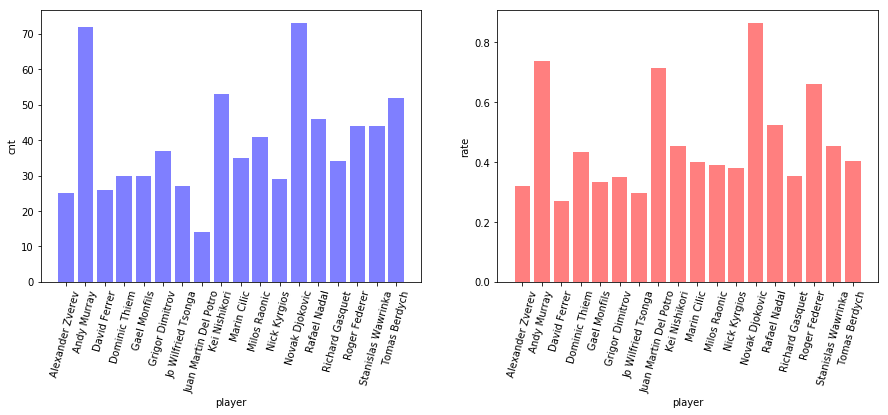

In [6]:
df_tmp = df_matches[
    (df_matches['year'] >= 2015) &
    (df_matches['winner_name'].isin(arr_target_player)) &
    (df_matches['loser_name'].isin(arr_target_player))
]

arr_cnt = []
arr_rate = []

for player in arr_target_player:
    
    cnt_win = len(df_tmp[df_tmp['winner_name'] == player])
    cnt_lose = len(df_tmp[df_tmp['loser_name'] == player])
    
    arr_cnt.append(cnt_win+cnt_lose)
    arr_rate.append(cnt_win/(cnt_win+cnt_lose))
    
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

axs[0].bar(x=arr_target_player, height=arr_cnt, color='b', alpha=0.5)
axs[0].set(xlabel='player', ylabel='cnt')

for tick in axs[0].get_xticklabels():
    tick.set_rotation(75)

axs[1].bar(x=arr_target_player, height=arr_rate, color='r', alpha=0.5)
axs[1].set(xlabel='player', ylabel='rate')

for tick in axs[1].get_xticklabels():
    tick.set_rotation(75)
    
plt.show()

In [7]:
dic_target_player = {}

for player in arr_target_player:
    
    if player not in dic_target_player:
        
        dic_target_player[player] = len(dic_target_player)+1
        
dic_target_player

{'Alexander Zverev': 18,
 'Andy Murray': 4,
 'David Ferrer': 12,
 'Dominic Thiem': 16,
 'Gael Monfils': 9,
 'Grigor Dimitrov': 15,
 'Jo Wilfried Tsonga': 11,
 'Juan Martin Del Potro': 6,
 'Kei Nishikori': 8,
 'Marin Cilic': 14,
 'Milos Raonic': 7,
 'Nick Kyrgios': 17,
 'Novak Djokovic': 3,
 'Rafael Nadal': 2,
 'Richard Gasquet': 13,
 'Roger Federer': 1,
 'Stanislas Wawrinka': 5,
 'Tomas Berdych': 10}

In [8]:
LW = []

for player_a in arr_target_player:
    for player_b in arr_target_player:
        
        df_tmp = df_matches[
            (df_matches['year'] >= 2015) &
            (df_matches['winner_name'] == player_a) &
            (df_matches['loser_name'] == player_b)
        ]
        
        for _ in range(len(df_tmp)):
            
            LW.append([dic_target_player[player_b], dic_target_player[player_a]])
            
        df_tmp = df_matches[
            (df_matches['year'] >= 2015) &
            (df_matches['winner_name'] == player_b) &
            (df_matches['loser_name'] == player_a)
        ]
        
        for _ in range(len(df_tmp)):
            
            LW.append([dic_target_player[player_a], dic_target_player[player_b]])

LW = np.array(LW, dtype=np.int32)
LW

array([[ 2,  1],
       [ 2,  1],
       [ 3,  1],
       ...,
       [18, 16],
       [18, 16],
       [18, 16]], dtype=int32)

In [9]:
model = """
    data {
        int N;
        int G;
        int<lower=1, upper=N> LW[G, 2];
    }
    parameters {
        ordered[2] performance[G];
        vector<lower=0>[N] mu;
        real<lower=0> s_mu; 
        vector<lower=0>[N] s_pf;
    }
    model {
        for (g in 1:G)
            for (i in 1:2)
                performance[g, i] ~ normal(mu[LW[g, i]], s_pf[LW[g, i]]);
        
        mu ~ normal(0, s_mu);
        s_pf ~ gamma(10, 10);
    }
"""
fit1 = pystan.stan(model_code=model, data={'N': len(dic_target_player), 'G': len(LW), 'LW': LW}, iter=1000, chains=4)
la1 = fit1.extract()
fit1

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6c4bce0386a40eafc754cfc0da4a0886 NOW.


Inference for Stan model: anon_model_6c4bce0386a40eafc754cfc0da4a0886.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
performance[0,0]     0.89    0.02   0.89  -0.93   0.34   0.92    1.5   2.55   2000   1.01
performance[1,0]     0.93    0.02   0.87  -0.79   0.37   0.94    1.5   2.57   2000   1.01
performance[2,0]      2.3    0.04   0.77   0.79   1.82    2.3   2.79   3.82    386   1.01
performance[3,0]      2.3    0.03   0.77   0.78   1.85    2.3   2.78   3.86    511   1.01
performance[4,0]     2.32    0.04   0.74   0.79   1.85   2.33   2.79   3.78    408   1.01
performance[5,0]     1.14    0.04   1.23  -1.57   0.36   1.28   1.98   3.22   1136    1.0
performance[6,0]     1.04    0.04   1.23  -1.74   0.36   1.18   1.88   3.08    873    1.0
performance[7,0]     1.15    0.03   1.26  -1.58   0.37   1.23   2.01   3.35   1339    1.0
per

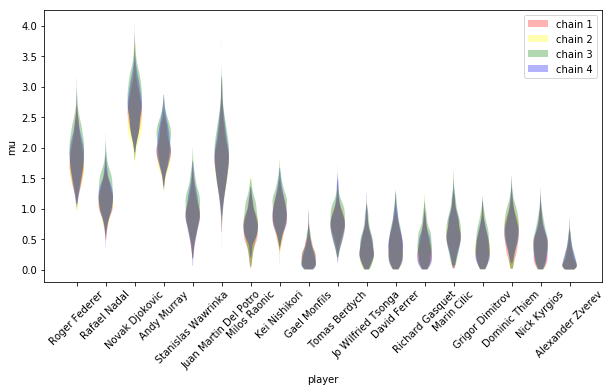

In [11]:
plt.figure(figsize=(10,5))

colors = ['red', 'yellow', 'green', 'blue']

for i, player in enumerate(arr_target_player):
    for j in range(4):
    
        g = plt.violinplot(la1['mu'][j*500:(j+1)*500, i], positions=[i], showmeans=False, showextrema=False, showmedians=False)
    
        for pc in g['bodies']:
        
            pc.set_facecolor(colors[j])
    
plt.legend(['chain 1', 'chain 2', 'chain 3', 'chain 4'])

plt.xticks(list(range(len(arr_target_player))), arr_target_player)
plt.xticks(rotation=45)

plt.xlabel('player')
plt.ylabel('mu')
plt.show()

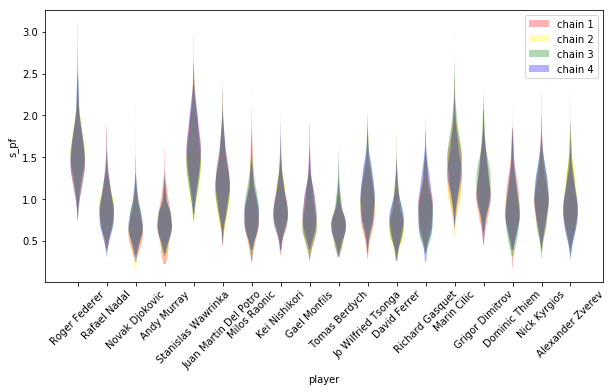

In [12]:
plt.figure(figsize=(10,5))

colors = ['red', 'yellow', 'green', 'blue']

for i, player in enumerate(arr_target_player):
    for j in range(4):
    
        g = plt.violinplot(la1['s_pf'][j*500:(j+1)*500, i], positions=[i], showmeans=False, showextrema=False, showmedians=False)
    
        for pc in g['bodies']:
        
            pc.set_facecolor(colors[j])
    
plt.legend(['chain 1', 'chain 2', 'chain 3', 'chain 4'])

plt.xticks(list(range(len(arr_target_player))), arr_target_player)
plt.xticks(rotation=45)

plt.xlabel('player')
plt.ylabel('s_pf')
plt.show()

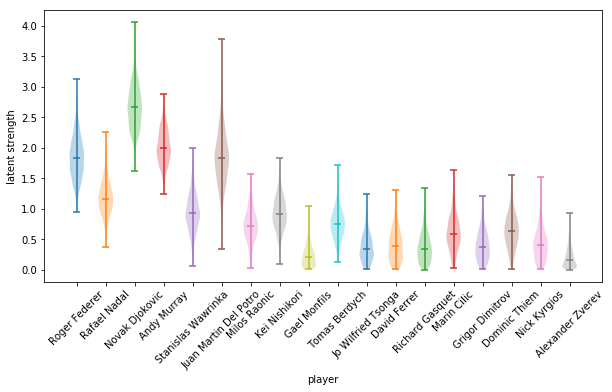

In [13]:
plt.figure(figsize=(10,5))
cmap = matplotlib.cm.get_cmap('tab10')

for i, player in enumerate(arr_target_player):
    
    g = plt.violinplot(la1['mu'][:, i], positions=[i], showmeans=False, showextrema=True, showmedians=True)
    c = cmap(i%10)
    
    for pc in g['bodies']:
        
        pc.set_facecolor(c)
        
    g['cbars'].set_edgecolor(c)
    g['cmaxes'].set_edgecolor(c)
    g['cmedians'].set_edgecolor(c)
    g['cmins'].set_edgecolor(c)
    
plt.xticks(list(range(len(arr_target_player))), arr_target_player)
plt.xticks(rotation=45)

plt.xlabel('player')
plt.ylabel('latent strength')
plt.show()

In [14]:
from matplotlib.colors import LinearSegmentedColormap

def generate_cmap(colors):
    
    values = range(len(colors))

    vmax = np.ceil(np.max(values))
    color_list = []
    
    for v, c in zip(values, colors):
        
        color_list.append(( v/ vmax, c))
        
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)

In [15]:
cm = generate_cmap(['white', 'violet'])

summary = np.zeros((len(arr_target_player), 4))

for i, player in enumerate(arr_target_player):
    
    samples = la1['mu'][:, i]

    median = np.median(samples, axis=0)
    std = np.std(samples, ddof=1)
    lower, upper = np.percentile(samples, q=[25.0, 75.0], axis=0)
    
    summary[i] = [median, std, lower, upper]
    
summary = pd.DataFrame(summary, index=arr_target_player, columns=['median', 'std', '25%', '75%'])

summary.style.background_gradient(cmap=cm, axis=0)

,median,std,25%,75%
Roger Federer,1.83334,0.349517,1.59303,2.07941
Rafael Nadal,1.16312,0.263714,0.98741,1.35028
Novak Djokovic,2.65741,0.35843,2.40431,2.91667
Andy Murray,1.99844,0.285411,1.81213,2.22782
Stanislas Wawrinka,0.929416,0.308205,0.732604,1.13863
Juan Martin Del Potro,1.8246,0.440516,1.54288,2.12622
Milos Raonic,0.717021,0.262862,0.551701,0.890484
Kei Nishikori,0.915045,0.263663,0.747072,1.114
Gael Monfils,0.206514,0.177146,0.0958657,0.338897
Tomas Berdych,0.744372,0.239954,0.587178,0.902718


* 対象期間は、ジョコビッチ1強時代であったため、ジョコビッチが1番強いと出ている
* デル・ポトロもBIG4に引けを取らない強さ
* ワウリンカと錦織が同じくらいの強さ
* 対象期間中では、若手は中堅以上には若干劣っている様子
* 若手の中では、ティエムが強い

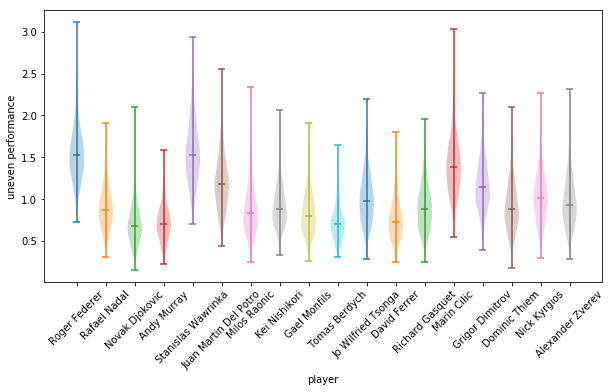

In [17]:
plt.figure(figsize=(10,5))
cmap = matplotlib.cm.get_cmap('tab10')

for i, player in enumerate(arr_target_player):
    
    g = plt.violinplot(la1['s_pf'][:, i], positions=[i], showmeans=False, showextrema=True, showmedians=True)
    c = cmap(i%10)
    
    for pc in g['bodies']:
        
        pc.set_facecolor(c)
        
    g['cbars'].set_edgecolor(c)
    g['cmaxes'].set_edgecolor(c)
    g['cmedians'].set_edgecolor(c)
    g['cmins'].set_edgecolor(c)
    
plt.xticks(list(range(len(arr_target_player))), arr_target_player)
plt.xticks(rotation=45)

plt.xlabel('player')
plt.ylabel('uneven performance')
plt.show()

In [18]:
cm = generate_cmap(['white', 'violet'])

summary = np.zeros((len(arr_target_player), 4))

for i, player in enumerate(arr_target_player):
    
    samples = la1['s_pf'][:, i]

    median = np.median(samples, axis=0)
    std = np.std(samples, ddof=1)
    lower, upper = np.percentile(samples, q=[25.0, 75.0], axis=0)
    
    summary[i] = [median, std, lower, upper]
    
summary = pd.DataFrame(summary, index=arr_target_player, columns=['median', 'std', '25%', '75%'])

summary.style.background_gradient(cmap=cm, axis=0)

,median,std,25%,75%
Roger Federer,1.52007,0.32652,1.32074,1.73128
Rafael Nadal,0.872197,0.243528,0.722531,1.03703
Novak Djokovic,0.680684,0.227782,0.546015,0.836206
Andy Murray,0.701431,0.2051,0.57564,0.841949
Stanislas Wawrinka,1.5316,0.355909,1.29774,1.78729
Juan Martin Del Potro,1.17387,0.315816,0.969282,1.39647
Milos Raonic,0.833744,0.274321,0.666432,1.01868
Kei Nishikori,0.87903,0.244855,0.732885,1.05624
Gael Monfils,0.800812,0.250581,0.64578,0.991395
Tomas Berdych,0.698418,0.19301,0.579613,0.817314


* ワウリンカが勝負ムラが一番大きく、BIG4に限らず、同じ選手に勝ったり負けたりしている
* BIG4の中では、この期間では、若干フェデラー、ナダルが勝ったり負けたりが多く、勝負ムラが少し大きめに出ている
* デル・ポトロは、マレー、ワウリンカに1勝1敗で、それ以外は安定して勝っていそうだが、なぜか大きめに出た（データが少ないため？）
* チリッチも、ジョコビッチ、マレーに勝ったことがあり、その他選手とも勝ったり負けたりが多く、勝負ムラが大きく出ている
* 若手選手も全体的に勝負ムラは少し高め、まだパフォーマンスを安定して発揮できていないことが多いということ？

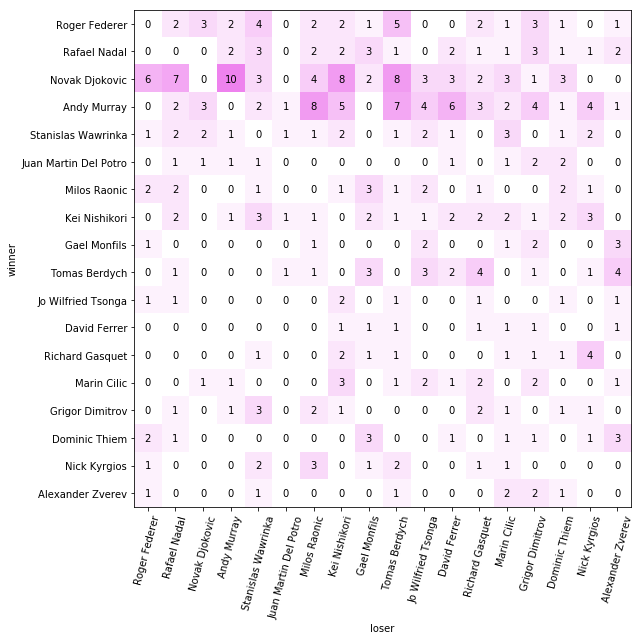

In [19]:
cm = generate_cmap(['white', 'violet'])

df_tmp = df_matches[
    (df_matches['year'] >= 2015) &
    (df_matches['winner_name'].isin(arr_target_player)) &
    (df_matches['loser_name'].isin(arr_target_player))
]

summary = np.zeros((len(arr_target_player), len(arr_target_player)), dtype=np.int32)

for i in range(len(arr_target_player)):
    for j in range(i+1, len(arr_target_player)):
        
        summary[i, j] = len(df_tmp[
            (df_tmp['winner_name'] == arr_target_player[i]) &
            (df_tmp['loser_name'] == arr_target_player[j])
        ])
        
        summary[j, i] = len(df_tmp[
            (df_tmp['loser_name'] == arr_target_player[i]) &
            (df_tmp['winner_name'] == arr_target_player[j])
        ])
    
fig, axs = plt.subplots(figsize=(9, 9))
im = axs.imshow(summary, cmap=cm, interpolation='nearest')

axs.grid(False)
axs.set_xticks(list(range(len(arr_target_player))))
axs.set_yticks(list(range(len(arr_target_player))))
axs.set_xticklabels(arr_target_player)
axs.set_yticklabels(arr_target_player)
axs.set_ylabel('winner')
axs.set_xlabel('loser')

for tick in axs.get_xticklabels():
    tick.set_rotation(75)
    
for i in range(len(arr_target_player)):
    for j in range(len(arr_target_player)):
        
        text = axs.text(j, i, summary[i, j], ha='center', va='center', color='black')
        
fig.tight_layout()
plt.show()

* 次のアプローチでは、モデルに時系列方向の要素を加える
    * player_strong_time_series_bayesian_modeling.ipynb

In [21]:
!python --version

Python 3.6.6 :: Anaconda custom (64-bit)


In [22]:
!pip freeze

absl-py==0.2.2
alabaster==0.7.10
algopy==0.5.7
altair==2.1.0
anaconda-client==1.6.5
anaconda-navigator==1.6.9
anaconda-project==0.8.0
annoy==1.12.0
appdirs==1.4.3
arrow==0.12.1
asn1crypto==0.22.0
astor==0.7.1
astroid==1.5.3
astropy==2.0.2
attrs==18.1.0
audioread==2.1.6
Babel==2.5.0
backports.shutil-get-terminal-size==1.0.0
Baker==1.3
basemap==1.1.0
bayesian-optimization==0.6.0
bayespy==0.5.17
bcolz==1.2.1
beautifulsoup4==4.6.0
biopython==1.72
bitarray==0.8.1
bkcharts==0.2
blaze==0.11.3
bleach==1.5.0
blist==1.3.6
bokeh==0.13.0
Boruta==0.1.5
boto==2.48.0
boto3==1.7.54
botocore==1.10.54
Bottleneck==1.2.1
-e git+https://github.com/SohierDane/BigQuery_Helper@8615a7f6c1663e7f2d48aa2b32c2dbcb600a440f#egg=bq_helper
branca==0.3.0
bz2file==0.98
cachetools==2.1.0
cairocffi==0.8.1
CairoSVG==2.1.3
Cartopy==0.16.0
catboost==0.9.1.1
category-encoders==1.2.8
certifi==2018.4.16
cffi==1.10.0
chainer==4.2.0
chardet==3.0.4
click==6.7
click-plugins==1.0.3
cligj==0.4.0
cloudpickle==0.4.0
clyent==1.2.2
cmudi